# Library

In [125]:
# Python Library
import os, glob, sys
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
import numpy as np
from astropy.table import Table, vstack, hstack
from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings("ignore")

# Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
#
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')

In [126]:
plt.style.use('dark_background') # Dark 모드 스타일 적용

In [127]:
from astropy.visualization import ZScaleInterval, LinearStretch, LogStretch
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from matplotlib.colors import LogNorm  # LogNorm 추가
from matplotlib.patches import Circle

In [128]:
from astropy.stats import sigma_clipped_stats

In [129]:
def calc_weighted_median_zp(zp_arr, zperr_arr):
	weights = [1 / error for error in zperr_arr]

	weighted_sum = sum(value * weight for value, weight in zip(zp_arr, weights))
	total_weight = sum(weights)
	zp = weighted_sum / total_weight

	total_weight = sum(weights)
	weighted_diff_sum = sum(((value - zp) ** 2) * weight for value, weight in zip(zp_arr, weights))
	zperr = (weighted_diff_sum / (total_weight - 1)) ** 0.5

	print(f"zp = {zp:.3f}+/-{zperr:.3f}")
	return zp, zperr

In [130]:
def check_slope(x, y, yerr, plot=False, verbose=False):
	from sklearn.linear_model import LinearRegression

	model = LinearRegression()
	# x = mtbl[f'{filte}mag'].reshape(-1, 1)
	# y = zp_ps1_arr.reshape(-1, 1)
	x = x.reshape(-1, 1)
	y = y.reshape(-1, 1)
	model.fit(x, y, sample_weight=1 / yerr**2)

	# 회귀 결과 추출
	slope = model.coef_[0][0]  # 기울기
	intercept = model.intercept_[0]  # y 절편

	if plot:
		# 회귀선 그리기
		plt.scatter(x, y, label='Data', alpha=0.5)
		plt.plot(x, model.predict(x), color='red', label=f'Linear Regression (a={slope:.3f}, b={intercept:.3f})')
		plt.xlabel(r"$\rm m_{PS1}$")
		plt.ylabel('ZP')
		plt.ylim([intercept+2, intercept-2])
		plt.title('Weighted Linear Regression')
		plt.legend()

		plt.show()

	if verbose:
		# 회귀 결과 출력
		print(f"Slope (기울기): {slope}")
		print(f"Intercept (y 절편): {intercept}")
	return (slope, intercept)

# Input

In [131]:
tname = 'LTT1020'
tra, tdec = 28.709, -27.477 # [deg], [deg]
radius = 1.5 # [deg]

## Source EXtractor

In [132]:
#	Source EXtractor
imlist = sorted(glob.glob('../data/spss/LTT1020/C*m.fits'))
for _inim in imlist:
	inim = os.path.basename(_inim)
	outcat = inim.replace('.fits', '.cat')
	sexcom = f"sex -c simple.sex -CATALOG_NAME {outcat} {inim}"
	print(sexcom)

sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-060223-u-360.com.cat Calib-7DT01-LTT1020-20231011-060223-u-360.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-060857-g-70.com.cat Calib-7DT01-LTT1020-20231011-060857-g-70.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-061211-r-70.com.cat Calib-7DT01-LTT1020-20231011-061211-r-70.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-061640-i-210.com.cat Calib-7DT01-LTT1020-20231011-061640-i-210.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-062417-z-420.com.cat Calib-7DT01-LTT1020-20231011-062417-z-420.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-063158-m400-210.com.cat Calib-7DT01-LTT1020-20231011-063158-m400-210.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-063807-m425-210.com.cat Calib-7DT01-LTT1020-20231011-063807-m425-210.com.fits
sex -c simple.sex -CATALOG_NAME Calib-7DT01-LTT1020-20231011-

## Read Tables

In [133]:
catlist = sorted(glob.glob('../data/spss/LTT1020/C*cat'))
print(f"{len(catlist)} catalogs found")

9 catalogs found


- PS1

In [134]:
ps1tbl = Table.read('../data/spss/LTT1020/ps1-LTT1020.cat', format='ascii')
c_ps1 = SkyCoord(ra=ps1tbl['RA_ICRS'], dec=ps1tbl['DE_ICRS'], frame='icrs')

- Gaia

In [135]:
gtbl = Table.read('../output/gaia-LTT1020.cat', format='csv')
# gtbl = Table.read('../output/LTT1020.pre.csv', format='csv')
c_gaia = SkyCoord(ra=gtbl['ra'], dec=gtbl['dec'], unit='deg', frame='icrs')

- Spatial Distribution

# Analysis

In [136]:
nn = 8
incat = catlist[nn]

inim = imlist[nn]
#	Image
filte = inim.split('-')[-2]
data = fits.getdata(inim)
# bkg = np.median(data)
print(f"{os.path.basename(inim)} (bkg={bkg:.3f})")
print(os.path.basename(incat))

#	Table
intbl = Table.read(incat, format='ascii.sextractor')
intbl['SNR'] = intbl['FLUX_AUTO']/intbl['FLUXERR_AUTO']
c_7dt = SkyCoord(ra=intbl['ALPHA_J2000'], dec=intbl['DELTA_J2000'])

Calib-7DT01-LTT1020-20231011-064810-m675-105.com.fits (bkg=1.101)
Calib-7DT01-LTT1020-20231011-064810-m675-105.com.cat


In [137]:
indx_select = np.where(
	(intbl['FLAGS']==0) &
	(intbl['CLASS_STAR']>0.9)
)

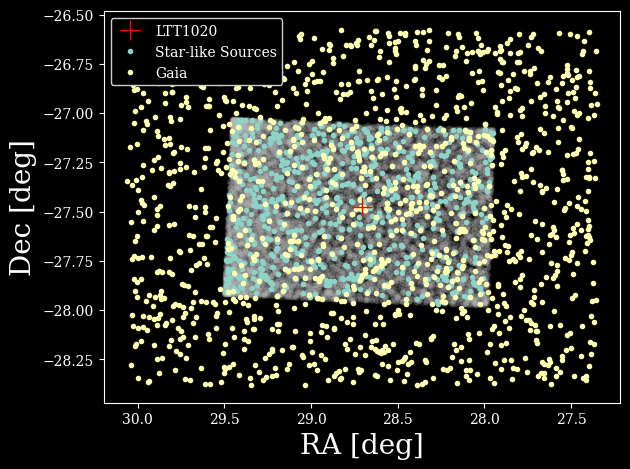

In [145]:
plt.plot(tra, tdec, '+', c='r', ms=15, label=tname, zorder=999)
plt.plot(intbl['ALPHA_J2000'], intbl['DELTA_J2000'], '.', alpha=0.1, c='silver',)
plt.plot(intbl['ALPHA_J2000'][indx_select], intbl['DELTA_J2000'][indx_select], '.', label='Star-like Sources')
plt.plot(gtbl['ra'], gtbl['dec'], '.', label='Gaia')
plt.legend(framealpha=1.0)

xl, xr = plt.xlim()
plt.xlim([xr, xl])

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()

## Matching with Gaia

In [139]:
indx_match, sep, _ = c_7dt.match_to_catalog_sky(c_gaia)
_mtbl = hstack([intbl, gtbl[indx_match]])
_mtbl = _mtbl[(sep.arcsec<2)]
print(f"Matched {len(_mtbl)} sources")

Matched 326 sources


In [140]:
_zp_gaia_arr = _mtbl[f'{filte}']-_mtbl['MAG_AUTO']
_zperr_gaia_arr = _mtbl[f'{filte}err']

In [141]:
mtbl = _mtbl[
	# (sep.arcsec<2)
	# (sep.arcsec<2) &
	# (~_mtbl[f'{filte}'].mask) &
	(_mtbl['FLAGS']==0)
	#
	# (~_mtbl[f'{filte}'].mask) &
	# (_mtbl[f'{filte}']>14) &
	# (_mtbl[f'{filte}']<18) &
	# (_mtbl['SNR']>50)
	]
print(f"Selected {len(mtbl)} sources")

Selected 291 sources


In [142]:
zp_gaia_arr = mtbl[f'{filte}']-mtbl['MAG_AUTO']
zperr_gaia_arr = mtbl[f'{filte}err']

- 3.0 Sigma Clipping
Alive: 282
Exile: 9


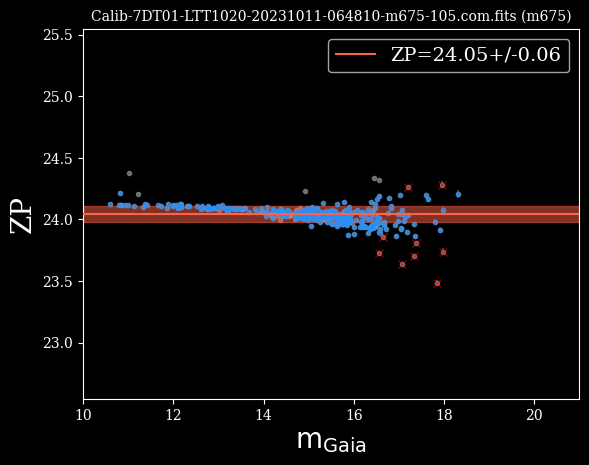

In [143]:
from astropy.stats import sigma_clip

sigma = 3.0
maxiters = None

#	SIGMA CLIPPING
zp_gaia_clip_arr = sigma_clip(
	zp_gaia_arr.copy(),
	sigma=sigma,
	maxiters=maxiters,
	cenfunc=np.median,
	copy=False
	)
indx_alive = np.where( zp_gaia_clip_arr.mask == False )
indx_exile = np.where( zp_gaia_clip_arr.mask == True )

print(f"- {sigma} Sigma Clipping")
print(f"Alive: {len(zp_gaia_arr[indx_alive])}")
print(f"Exile: {len(zp_gaia_arr[indx_exile])}")

zp_gaia, zperr_gaia = np.median(zp_gaia_arr[indx_alive]), np.std(zp_gaia_arr[indx_alive])

plt.title(f"{os.path.basename(inim)} ({filte})", fontsize=10)

plt.plot(_mtbl[f'{filte}'], _zp_gaia_arr, '.', c='silver', alpha=0.5, zorder=0)
plt.errorbar(mtbl[f'{filte}'], zp_gaia_arr, yerr=zperr_gaia_arr, ls='none', c='grey', alpha=0.5, zorder=0)
plt.plot(mtbl[f'{filte}'][indx_alive], zp_gaia_arr[indx_alive], '.', color='dodgerblue', alpha=0.5)
plt.plot(mtbl[f'{filte}'][indx_exile], zp_gaia_arr[indx_exile], 'xr', alpha=0.5)

plt.axhline(y=zp_gaia, ls='-', color='tomato', zorder=999, label=f'ZP={zp_gaia:.2f}+/-{zperr_gaia:.2f}')
plt.axhspan(ymin=zp_gaia-zperr_gaia, ymax=zp_gaia+zperr_gaia, color='tomato', zorder=0, alpha=0.5)
plt.xlabel(r"$\rm m_{Gaia}$")
plt.ylabel("ZP")
plt.xlim([10, 21])
plt.ylim(zp_gaia-1.5, zp_gaia+1.5)
plt.legend(fontsize=14)